<a href="https://colab.research.google.com/github/davidguzmanr/Aprendizaje-Profundo/blob/main/Tareas/Tarea-2/Tarea_2_ejercicio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2: redes convolucionales

- **E. David Guzmán Ramírez**
- **Introducción al Aprendizaje Profundo 2021-II**
- **Licenciatura en Ciencia de Datos CU UNAM**

In [ ]:
! pip install torchinfo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

import random
from collections import Counter
from itertools import islice as take
from tqdm import trange, tqdm

sns.set_style('darkgrid')

In [2]:
def set_seed(seed=42):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
# reproducibilidad
set_seed()

## Ejercicio 1

Diseña y entrena una red convolucional para el conjunto de datos CIFAR10. Explora diferentes diseños buscando mejorar tus resultados en el ejercicio 4 de la tarea 1. Discute tus resultados.

### Carga de datos y exploración

El conjunto de datos CIFAR-10 contiene 60,000 imágenes a color de 32x32 en 10 clases diferentes. Las 10 clases diferentes representan aviones, automóviles, pájaros, gatos, ciervos, perros, ranas, caballos, barcos y camiones. Hay 6.000 imágenes de cada clase (ver [CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) para cargar el dataset de manera sencilla).

In [3]:
# Los pasa a tensores y las normaliza con media=0.5 y desv_est=0.5 en cada canal.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes_dict = dict(zip(range(0,10), classes))

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [16]:
dir(trainset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_integrity',
 '_format_transform_repr',
 '_load_meta',
 '_repr_indent',
 'base_folder',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'filename',
 'meta',
 'root',
 'target_transform',
 'targets',
 'test_list',
 'tgz_md5',
 'train',
 'train_list',
 'transform',
 'transforms',
 'url']

In [14]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [5]:
dir(trainset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_integrity',
 '_format_transform_repr',
 '_load_meta',
 '_repr_indent',
 'base_folder',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'filename',
 'meta',
 'root',
 'target_transform',
 'targets',
 'test_list',
 'tgz_md5',
 'train',
 'train_list',
 'transform',
 'transforms',
 'url']

In [8]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [13]:
trainset.__getitem__(1)[0].shape

torch.Size([3, 32, 32])

Vemos que hay 50,000 imágenes en el dataset de entrenamiento y 10,000 en el de prueba. Además, tanto en el dataset de entrenamiento como el de prueba las clases están completamente balanceadas.

In [ ]:
len(trainset), len(testset)

(50000, 10000)

In [ ]:
train_class_counter = Counter([classes_dict[y] for (x, y) in trainset])
train_class_counter

Counter({'frog': 5000,
         'truck': 5000,
         'deer': 5000,
         'car': 5000,
         'bird': 5000,
         'horse': 5000,
         'ship': 5000,
         'cat': 5000,
         'dog': 5000,
         'plane': 5000})

In [ ]:
test_class_counter = Counter([classes_dict[y] for (x, y) in testset])
test_class_counter

Counter({'cat': 1000,
         'ship': 1000,
         'plane': 1000,
         'frog': 1000,
         'car': 1000,
         'truck': 1000,
         'dog': 1000,
         'horse': 1000,
         'deer': 1000,
         'bird': 1000})

Ahora veamos algunas imágenes en el dataset.

In [ ]:
def show_images(images, true_labels, pred_labels=None):
    """
    Muestra un lote de imágenes con su respectiva clase.
    """
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

    for i, _ in enumerate(axes):
        axes[i].imshow(images[i].permute(1,2,0).numpy()/2 + 0.5) # Desnormalizamos
        axes[i].axis('off')

    if pred_labels:
        for i, _ in enumerate(axes):
            axes[i].set_title(f'true_label={classes_dict[true_labels[i].item()]}\npred_label={classes_dict[pred_labels[i].item()]}')
    else:
        for i, _ in enumerate(axes):
            axes[i].set_title(f'true_label={classes_dict[true_labels[i].item()]}')

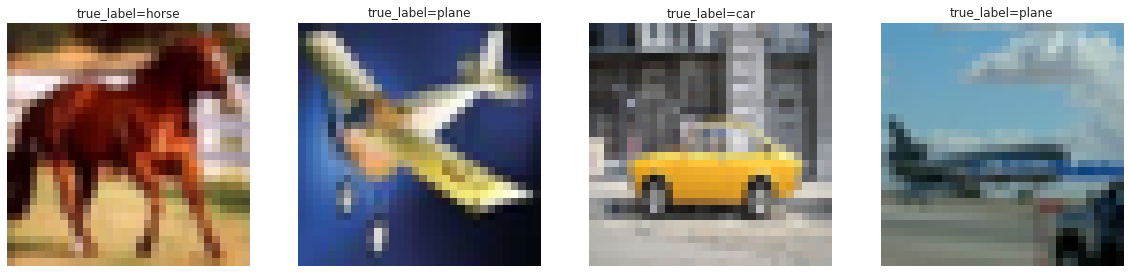

In [ ]:
images, true_labels = next(iter(trainloader))
show_images(images, true_labels)

### Definición del modelo

Ahora definamos nuestro modelo, usaré un bloque sencillo formado por:

- `nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=0)`
- `nn.BatchNorm2d(num_features=3)`
- `nn.ReLU()`

Este bloque lo iré apilando y combinando con `MaxPool2d(kernel_size=2)`. Para la parte del clasificador usaré una `fully connected` sencilla dada por:

- `nn.Linear(in_features, 50)` (`in_features` cambia dependiendo de cuántos bloques use)
- `nn.ReLU()`
- `nn.Linear(50, 30)`
- `nn.ReLU()`
- `nn.Linear(30, 10)`

Además, para aprovechar el ejercicio 2 de esta tarea también usaré el bloque de ResNet para experimentar.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda:0


In [ ]:
class MyBlock(nn.Module):

    def __init__(self):
        # Inicilización del objeto padre
        super(MyBlock, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),
        )
        
    def forward(self, x):
        
        return self.conv(x)

In [ ]:
class ResNetBlock(nn.Module):

    def __init__(self):
        # Inicilización del objeto padre
        super(ResNetBlock, self).__init__()
        
        # Primera convolución
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU()
        )
        
        # Segunda convolución
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        
        return self.conv1(x) + self.conv2(x)

In [ ]:
class CNN(nn.Module):
    # inicializador
    def __init__(self):        
        # inicilización del objeto padre
        super(CNN, self).__init__()
               
        # definición de capas
        
        # Usando el bloque MyBlock
#         self.conv = nn.Sequential(
#             # [M, 3, 32, 32] -> [M, 3, 30, 30]
#             MyBlock(),
#             # [M, 3, 30, 30] -> [M, 3, 15, 15]
#             nn.MaxPool2d(kernel_size=2),    
#             # [M, 3, 15, 15] -> [M, 3, 13, 13]
#             MyBlock(),
#             # [M, 3, 13, 13] -> [M, 3, 6, 6]
#             nn.MaxPool2d(kernel_size=2),    
#         )

        # Usando el bloque de ResNet
        self.conv = nn.Sequential(
            # [M, 3, 32, 32] -> [M, 3, 32, 32]
            ResNetBlock(),
            # [M, 3, 32, 32] -> [M, 3, 16, 16]
            nn.MaxPool2d(kernel_size=2),  
            # [M, 3, 16, 16] -> [M, 3, 16, 16]
            ResNetBlock(),
            # [M, 3, 16, 16] -> [M, 3, 8, 8]
            nn.MaxPool2d(kernel_size=2),  
        )
        
        self.flatten = nn.Flatten()
        
        # Con 1 bloque MyBlock
        # in_features = 3*15*15
        
        # Con 2 bloques MyBlock
        # in_features = 3*6*6
        
        # Con 1 bloque ResNetBlock
        # in_features = 3*16*16
        
        # Con 2 bloques ResNetBlock
        in_features = 3*8*8

        self.cls = nn.Sequential(
            nn.Linear(in_features, 50),
            nn.ReLU(),
            nn.Linear(50, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
        )
    
    # método para inferencia
    def forward(self, x):        
        x = self.conv(x)
        x = self.flatten(x)
        x = self.cls(x)
        
        return x

In [ ]:
def train_epoch(dataloader, model, opt):

    # por cada lote
    for x, y_true in dataloader:
        # Los pasamos a la GPU, en caso de que haya
        x, y_true = x.to(device), y_true.to(device)
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()

In [ ]:
def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):
            # Los pasamos a la GPU, en caso de que haya
            x, y_true = x.to(device), y_true.to(device)

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc

In [ ]:
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20, trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

Instanciamos nuestro modelo y vemos cuántos parámetros tiene.

In [ ]:
# Definimos nuestro modelo y probamos con unos datos sintéticos
model = CNN()
x = torch.zeros(1,3,32,32)
model(x)

tensor([[ 0.0150,  0.1307,  0.0491, -0.3094,  0.0149, -0.1122, -0.0408, -0.0853,
         -0.0684,  0.1098]], grad_fn=<AddmmBackward>)

In [ ]:
# Lo movemos a la GPU, en caso de que haya
model.to(device)

CNN(
  (conv): Sequential(
    (0): ResNetBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (conv2): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResNetBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
summary(model, input_size=(1, 3, 32, 32), device=device, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 3, 8, 8]              --
|    └─ResNetBlock: 2-1                  [1, 3, 32, 32]            --
|    |    └─Sequential: 3-1              [1, 3, 32, 32]            180
|    |    └─Conv2d: 3-2                  [1, 3, 32, 32]            12
|    └─MaxPool2d: 2-2                    [1, 3, 16, 16]            --
|    └─ResNetBlock: 2-3                  [1, 3, 16, 16]            --
|    |    └─Sequential: 3-3              [1, 3, 16, 16]            180
|    |    └─Conv2d: 3-4                  [1, 3, 16, 16]            12
|    └─MaxPool2d: 2-4                    [1, 3, 8, 8]              --
├─Flatten: 1-2                           [1, 192]                  --
├─Sequential: 1-3                        [1, 10]                   --
|    └─Linear: 2-5                       [1, 50]                   9,650
|    └─ReLU: 2-6                         [1, 50]                   --
|    └─Lin

### Entrenamiento

In [ ]:
loss_hist, acc_hist = train(model, trainloader, testloader, lr=0.001)

  5%|▌         | 1/20 [01:30<28:45, 90.83s/it]

E00 loss=[144.66,146.76] acc=[48.05,47.24]


 10%|█         | 2/20 [03:01<27:12, 90.68s/it]

E01 loss=[132.06,136.00] acc=[53.06,51.30]


 15%|█▌        | 3/20 [04:32<25:41, 90.65s/it]

E02 loss=[121.56,126.83] acc=[57.27,54.53]


 20%|██        | 4/20 [06:02<24:10, 90.63s/it]

E03 loss=[118.46,125.96] acc=[58.40,55.98]


 25%|██▌       | 5/20 [07:33<22:40, 90.70s/it]

E04 loss=[112.65,122.18] acc=[60.62,56.81]


 30%|███       | 6/20 [09:02<21:02, 90.18s/it]

E05 loss=[108.51,119.26] acc=[62.20,57.83]


 35%|███▌      | 7/20 [10:32<19:30, 90.01s/it]

E06 loss=[107.06,118.73] acc=[62.65,58.80]


 40%|████      | 8/20 [12:00<17:53, 89.45s/it]

E07 loss=[104.13,117.06] acc=[63.87,59.36]


 45%|████▌     | 9/20 [13:28<16:20, 89.14s/it]

E08 loss=[105.24,120.17] acc=[63.40,58.33]


 50%|█████     | 10/20 [15:00<14:57, 89.73s/it]

E09 loss=[101.35,116.62] acc=[64.96,59.37]


 55%|█████▌    | 11/20 [16:30<13:28, 89.85s/it]

E10 loss=[101.21,116.88] acc=[64.92,59.95]


 60%|██████    | 12/20 [17:56<11:51, 88.92s/it]

E11 loss=[ 98.30,114.97] acc=[65.85,60.60]


 65%|██████▌   | 13/20 [19:28<10:27, 89.62s/it]

E12 loss=[ 98.21,116.97] acc=[66.06,60.48]


 70%|███████   | 14/20 [20:58<08:59, 89.92s/it]

E13 loss=[ 97.96,116.43] acc=[65.98,59.88]


 75%|███████▌  | 15/20 [22:29<07:30, 90.13s/it]

E14 loss=[ 98.14,117.55] acc=[66.02,60.00]


 80%|████████  | 16/20 [24:01<06:02, 90.62s/it]

E15 loss=[ 97.50,116.90] acc=[66.23,59.82]


 85%|████████▌ | 17/20 [25:30<04:30, 90.24s/it]

E16 loss=[ 96.56,116.24] acc=[66.33,60.40]


 90%|█████████ | 18/20 [26:58<02:59, 89.63s/it]

E17 loss=[ 95.63,115.55] acc=[66.88,60.07]


 95%|█████████▌| 19/20 [28:27<01:29, 89.32s/it]

E18 loss=[ 94.60,115.08] acc=[67.28,60.40]


100%|██████████| 20/20 [29:57<00:00, 89.89s/it]

E19 loss=[ 96.38,117.49] acc=[66.66,60.30]


### Gráficas de pérdida y accuracy

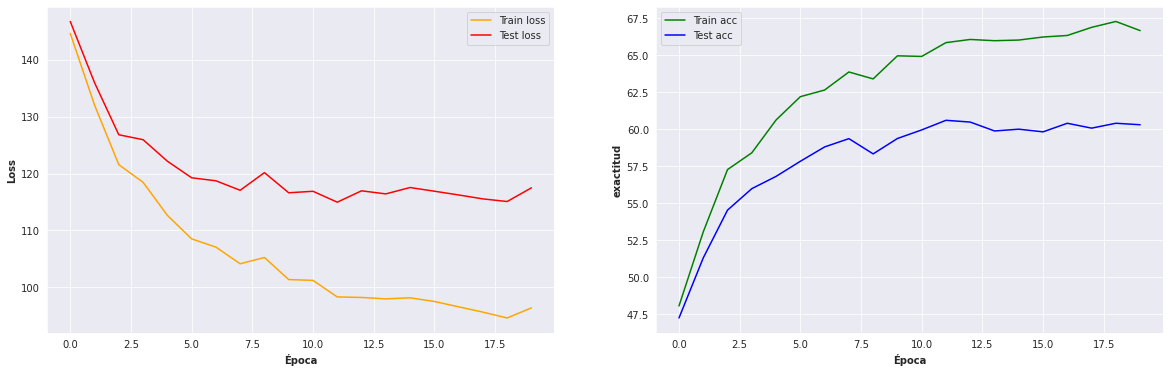

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

trn_loss, tst_loss = zip(*loss_hist)
ax0.plot(trn_loss, 'orange', label='Train loss')
ax0.plot(tst_loss, 'red', label='Test loss')
ax0.set_xlabel('Época', weight='bold')
ax0.set_ylabel('Loss', weight='bold')
ax0.legend()

trn_acc, tst_acc = zip(*acc_hist)
ax1.plot(trn_acc, 'green', label='Train acc')
ax1.plot(tst_acc, 'blue', label='Test acc')
ax1.set_xlabel('Época', weight='bold')
ax1.set_ylabel('exactitud', weight='bold')
ax1.legend()

plt.show()

### Evaluación final

In [ ]:
# Evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trainloader, model)
# Evaluamos en prueba
tst_loss, tst_acc = eval_epoch(testloader, model)

print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 96.42,117.56] acc=[66.68,60.65]


### Predicciones

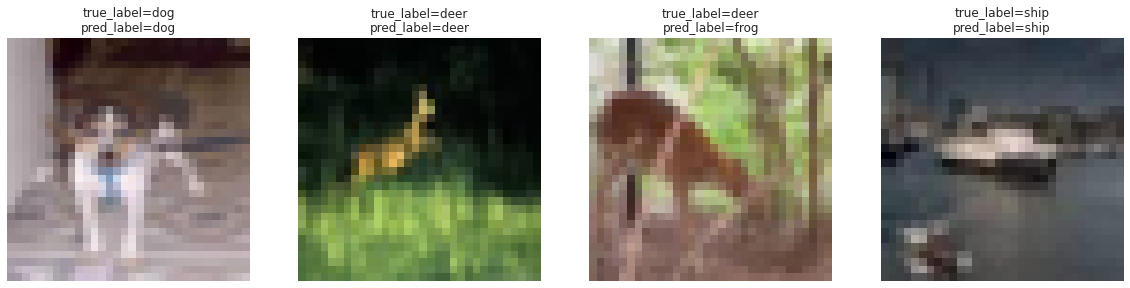

In [ ]:
with torch.no_grad(): 
    images, true_labels = next(iter(testloader))
    images = images.to(device)
    y_lgts = model(images.to(device))
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    pred_labels = list(y_pred.cpu().numpy())

    show_images(images.cpu(), true_labels, pred_labels)

### Discusión

|           **Modelo**          | **# de parámetros** | **Tiempo (GPU)** | **Accuracy (train, test)** |
|:-----------------------------:|:-------------------:|:----------------:|:--------------------------:|
|         FCN (tarea 1)         |        61,670       |       09:35      |        51.33, 46.14        |
|  CNN (con 1 bloque *MyBlock*) |        35,730       |       15:16      |        55.34, 49.27        |
| CNN (con 2 bloques *MyBlock*) |        7,470        |       19:12      |        51.92, 48.92        |
|  CNN (con 1 bloque *ResNet*)  |        40,482       |       19:56      |        73.60, 54.36        |
|  CNN (con 2 bloques *ResNet*) |        11,874       |       29:57      |        66.68, 60.65       |

Usando el bloque que yo definí se pueden mejorar los resultados del clasificador de la tarea 1 y con muchos menos parámetros, aunque el tiempo de entrenamiento es mayor debido a que la arquitectura es un poco más complicada. Usar más de estos bloques parece no ayudar, probablemente se deba a que al hacer el MaxPool se pierdan algunas características de las imágenes que de por sí ya están bastante pixeladas.

En cuanto al bloque de ResNet se obtienen resultados claramente mejores, aunque con únicamente un bloque de ResNet parece estar sobreajustándose, pues como se observa en la tabla de arriba con un bloque de ResNet hay una diferencia notable en el accuracy en train y test. Al usar dos bloques de ResNet se reduce un poco el rendimiento pero parece disminuir el sobreajuste, por lo que para estos experimentos este modelo con dos bloques de ResNet parece ser el mejor.